# Flux model fits and plots

In this notebook, flux model fits are generated from tabulated data taken from the following publications.
Flux points for sources are taken from:
- eHWC J1907+063 - https://arxiv.org/abs/1909.08609
- VelaX - https://www.aanda.org/articles/aa/full_html/2012/12/aa19919-12/aa19919-12.html
- RX J1713.7-3946 - https://www.aanda.org/articles/aa/full_html/2018/04/aa29790-16/aa29790-16.html
- Westerlund 1 - https://www.mpi-hd.mpg.de/hfm/HESS/pages/publications/auxiliary/AA537_A114.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from astropy.table import Table
import astropy.units as u

from gammapy.estimators import FluxPoints
from gammapy.modeling.models import NaimaSpectralModel
from naima.models import ExponentialCutoffPowerLaw, InverseCompton

from scipy.optimize import curve_fit

import sys

sys.path.append("../src")
from flux_utils import PionDecayKelner06, SourceModel
import plot_utils

from configure_analysis import AnalysisConfig
analysisconfig = AnalysisConfig()

%matplotlib inline
plt.rcdefaults()
plot_utils.mpl_settings()

For the performance of the fit, several parameters are set:
the name of source file, sorce name, title plot, label plot, some initial parameters for fit performing, limits for X axis. They are retrieved for the current source. Source parameters can be found in data/models.

The source to be evaluated is taken from the `analysis_config.yml`.

In [2]:
source_name = analysisconfig.get_source()
model = SourceModel(sourcename=source_name)
source_tuple = model.get_sourcetuple

In [6]:
print ("working with sourcetuple:")
for i in source_tuple:
    print(f"\t{i}")

working with sourcetuple:
	FP_VelaX
	VelaX
	Vela X
	H.E.S.S. (2012)
	[2e+30, 10, -4.0, 20, 1]
	[4e+30, 10, 1.0, 20, 1]
	[2e+30, -4.0, 20]
	[4e+30, 1.0, 20]
	[0.1, 100.0]


In [4]:
FP_df = pd.read_csv(analysisconfig.get_file("models/"+source_tuple[0]+".csv"))

The following is a lot of formatting to get to a usable model.

First, generate a `astropy.table.Table` from the `csv` and a `FluxPoints` object

In [5]:
FP_table = Table()
FP_table["e_ref"] = FP_df["e_ref"].values
FP_table["dnde"] = FP_df["dnde"].values
FP_table["dnde_err"] = FP_df["dnde_err"].values
FP_table["e_ref"].unit = "TeV"
FP_table["dnde"].unit = "TeV-1 cm-2 s-1"
FP_table["dnde_err"].unit = "TeV-1 cm-2 s-1"
FP_table.meta["SED_TYPE"] = "dnde"

FP = FluxPoints(FP_table)

Check the content of `astropy.table`

In [6]:
FP_table[:4]

e_ref,dnde,dnde_err
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64
0.7166177640460887,1.0444151853831484e-11,3.100098844302782e-12
0.8648090438022308,1.292089554454668e-11,2.1345522744789398e-12
1.048113134154686,9.07853564759317e-12,1.6627674551192741e-12
1.2702701826031997,8.399644451497578e-12,6.673100080410105e-13


Get and check the source distance.

In [7]:
source_dist = model.get_distance
source_dist

<Quantity 0.29 kpc>

## Using a Exponential Cutoff Power Law (ECPL)

Define a proton spectrum `ExponentialCutoffPowerLaw` (parameters do not matter here)

In [8]:
ECPL_PD = ExponentialCutoffPowerLaw(
    amplitude=source_tuple[4][0] / u.eV,
    e_0=source_tuple[4][1] * u.TeV,
    alpha=source_tuple[4][2],
    e_cutoff=source_tuple[4][3] * u.TeV,
    beta=source_tuple[4][4],
)

gamma_ECPL_PD = NaimaSpectralModel(
    PionDecayKelner06(ECPL_PD, particle_type="gamma"), distance=source_dist
)

Define the electron spectrum

In [9]:
ECPL_IC = ExponentialCutoffPowerLaw(
    amplitude=source_tuple[5][0] / u.eV,
    e_0=source_tuple[5][1] * u.TeV,
    alpha=source_tuple[5][2],
    e_cutoff=source_tuple[5][3] * u.TeV,
    beta=source_tuple[5][4],
)

gamma_ECPL_IC = NaimaSpectralModel(
    InverseCompton(ECPL_IC, seed_photon_fields="CMB"), distance=source_dist
)

These functions give the predicted flux at the energies of the flux points
(note that `x` is unused here)

In [10]:
def PD_pred(x, amp, alpha, e_cut):
    gamma_ECPL_PD.parameters["amplitude"].value = amp
    gamma_ECPL_PD.parameters["alpha"].value = alpha
    gamma_ECPL_PD.parameters["e_cutoff"].value = e_cut
    return gamma_ECPL_PD(FP.e_ref).value


def IC_pred(x, amp, alpha, e_cut):
    gamma_ECPL_IC.parameters["amplitude"].value = amp
    gamma_ECPL_IC.parameters["alpha"].value = alpha
    gamma_ECPL_IC.parameters["e_cutoff"].value = e_cut
    return gamma_ECPL_IC(FP.e_ref).value

Fit the proton model to the flux points

In [11]:
popt_ECPL_PD, cov_ECPL_PD = curve_fit(
    PD_pred,  # function that is fitted
    [1, 2, 3],  # arbitrary
    FP_df["dnde"],  # flux point values
    sigma=FP_df["dnde_err"],  # flux point errors
    p0=source_tuple[6],  # initial guess for parameters
)

chi2_PD = plot_utils.chi2(
    gamma_ECPL_PD,
    FP.e_ref,
    u.Quantity(FP_table["dnde"]),
    u.Quantity(FP_table["dnde_err"]),
) / (
    len(FP.table) - 3
)  # chi^2 / ndof

print("fit parameters: amplitude, index, cutoff energy")
print(popt_ECPL_PD)
print("their uncertainties")
print(np.sqrt(np.diag(cov_ECPL_PD)))
print(f"chi^2 / ndof = {chi2_PD.to('')}")

fit parameters: amplitude, index, cutoff energy
[ 4.03299345e+30 -4.93984967e+00  1.42777409e+01]
their uncertainties
[4.49571930e+31 9.89938575e+00 2.23199138e+01]
chi^2 / ndof = 1.7979729619664697


In [12]:
# Store results
if analysisconfig.get_value("write_model_fits", "io"):
    np.savetxt(
        analysisconfig.get_file("models/modelfits/input_model_PD_"+source_tuple[1]+".txt"),
        gamma_ECPL_PD.parameters.values,
    )

file is successufully written!


Fitting the electron model to the flux points and storing the results

In [13]:
popt_ECPL_IC, cov_ECPL_IC = curve_fit(
    IC_pred,  # function that is fitted
    [1, 2, 3],  # arbitrary
    FP_df["dnde"],  # flux point values
    sigma=FP_df["dnde_err"],  # flux point errors
    p0=source_tuple[7],  # initial guess for parameters
)

chi2_IC = plot_utils.chi2(
    gamma_ECPL_IC,
    FP.e_ref,
    u.Quantity(FP_table["dnde"]),
    u.Quantity(FP_table["dnde_err"]),
) / (
    len(FP.table) - 3
)  # chi^2 / ndof

print("fit parameters: amplitude, index, cutoff energy")
print(popt_ECPL_IC)
print("their uncertainties")
print(np.sqrt(np.diag(cov_ECPL_IC)))
print(f"chi^2 / ndof = {chi2_IC.to('')}")

fit parameters: amplitude, index, cutoff energy
[5.86430962e+30 5.77160482e-01 2.37144285e+01]
their uncertainties
[7.98414246e+29 3.98743703e-01 5.73285972e+00]
chi^2 / ndof = 1.7838501107057891


In [14]:
# Store results
if analysisconfig.get_value("write_model_fits", "io"):
    np.savetxt(analysisconfig.get_file("models/modelfits/input_model_IC_"+source_tuple[1]+".txt"),
        gamma_ECPL_IC.parameters.values,
    )

file is successufully written!


### Plot the best-fit gamma spectra together with the Flux Points
Reproduce Figure 6: Fit of hadronic (PD) and leptonic (IC) input models. The muon-neutrino prediction based on the best-fit PD model is shown as dashed line.

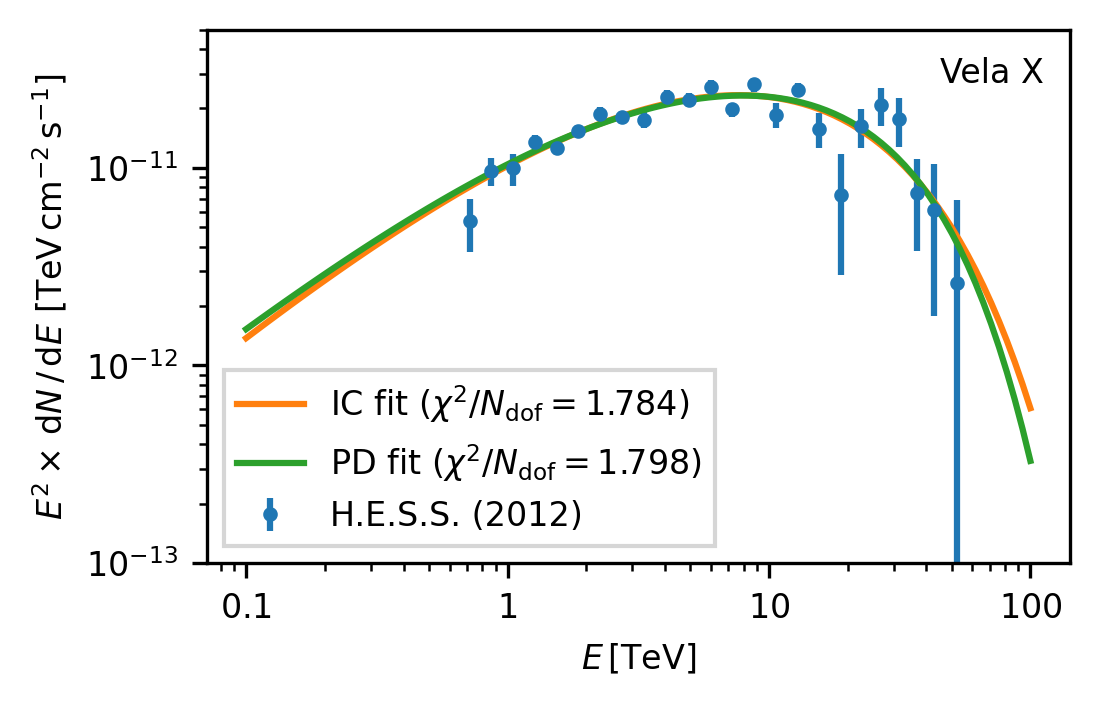

In [15]:
fig_width = 8.8 / 2.54
ax_width = 0.83
fig_height = 2.2
ax_height = fig_width * ax_width / 1.618 / fig_height  # golden ratio

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.add_axes([0.16, 0.18, ax_width, ax_height])
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, module="gammapy")
    FP.plot(energy_power=2, marker=".", markersize=5, label=source_tuple[3], ax=ax)
    gamma_ECPL_IC.plot(
        source_tuple[8] * u.TeV,
        energy_power=2,
        label=r"IC fit ($\chi^2/N_\mathrm{{dof}}={:.3f}$)".format(chi2_IC.value),
        ax=ax,
    )
    gamma_ECPL_PD.plot(
        source_tuple[8] * u.TeV,
        energy_power=2,
        label=r"PD fit ($\chi^2/N_\mathrm{{dof}}={:.3f}$)".format(chi2_PD.value),
        ax=ax,
    )

ax.set_xlabel("$E\,[\mathrm{TeV}]$")
ax.set_ylabel(
    r"$E^2\times\,\mathrm{d}N\,/\,\mathrm{d}E\,\,[\mathrm{TeV}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1}]$"
)
ax.set_ylim(1e-13, 5e-11)
ax.text(0.97, 0.95, source_tuple[2], ha="right", va="top", transform=ax.transAxes)
ax.legend(loc="lower left")

plot_utils.format_log_axis(ax.xaxis)
plt.show()

In [16]:
# Store plots
for form in ["png", "pdf"]:
        fig.savefig(analysisconfig.get_file("models/plots/fit_"+source_tuple[0]+"."+form), dpi=300)